For first-time users (if NDVI/NDWI/NDBI, LST data is not available):
Please use Colab, as it relies on pystac_client to fetch the data.

If you already have the data:
Check the directory containing the data, and then run the cells starting from "Correlation among features" onward.


# Import packages and libraries

In [2]:
# Import
!pip install pystac_client stackstac planetary-computer rioxarray rasterio geopandas --quiet
!pip install odc-stac --quiet
!pip install fiona shapely pyproj lxml --quiet
!pip install xgboost --quiet
!pip install shap --quiet
!pip install rasterstats --quiet
import warnings
warnings.filterwarnings('ignore')

import json
import requests
import subprocess
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from rasterstats import point_query
from pathlib import Path
from matplotlib.cm import RdYlGn, RdBu, jet
import stackstac
import pystac_client
import planetary_computer
from odc.stac import stac_load
import pandas as pd
from rasterio.transform import rowcol
from tqdm import tqdm
from datetime import datetime
from math import radians, cos
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.8/206.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.1/155.1 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 70.0 MB/s eta 0:00:00


# Get the NDVI/NDWI/NDBI from Sentinel-2

In [3]:
# Define area and time period (NYC)
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])
time_window = "2021-06-01/2021-09-01"

# Search STAC from Planetary Computer
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = stac.search(
    bbox=bounds,
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 30}},
)
items = list(search.get_items())
print("Number of scenes:", len(items))

# Load data
signed_items = [planetary_computer.sign(item) for item in items]
resolution = 10  # meters per pixel
scale = resolution / 111320.0  # degrees per pixel for EPSG:4326

data = stac_load(
    signed_items,
    bands=["B03", "B04", "B08", "B11"],
    crs="EPSG:4326",
    resolution=scale,
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds,
)

# Create median mosaic over time (cloud-free)
median = data.median(dim="time").compute()

# Calculate spectral indices
ndvi = (median.B08 - median.B04) / (median.B08 + median.B04)
ndwi = (median.B03 - median.B08) / (median.B03 + median.B08)
ndbi = (median.B11 - median.B08) / (median.B11 + median.B08)

# Save each index as GeoTIFF
def save_band_to_geotiff(band_data, filename, transform, crs="EPSG:4326"):
    band_data.rio.write_crs(crs, inplace=True)
    band_data.rio.write_transform(transform, inplace=True)
    band_data.rio.to_raster(filename)
    print(f"Saved {filename}")

# Define transform (Affine)
height = median.dims["latitude"]
width = median.dims["longitude"]
gt = rasterio.transform.from_bounds(lower_left[1], lower_left[0], upper_right[1], upper_right[0], width, height)

# Save process
save_band_to_geotiff(ndvi, "/content/ndvi_median.tif", gt)
save_band_to_geotiff(ndwi, "/content/ndwi_median.tif", gt)
save_band_to_geotiff(ndbi, "/content/ndbi_median.tif", gt)

# Collab download
from google.colab import files
files.download("/content/ndvi_median.tif")
files.download("/content/ndwi_median.tif")
files.download("/content/ndbi_median.tif")

Number of scenes: 10
Saved /content/ndvi_median.tif
Saved /content/ndwi_median.tif
Saved /content/ndbi_median.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Merging NDVI/NDWI/NDBI into uhi

In [6]:
# Load UHI data (uhi.csv - training data)
uhi_df = pd.read_csv("/content/uhi.csv")

# Open NDVI/NDWI/NDBI GeoTIFF files
tif_paths = {
    "NDVI": "/content/ndvi_median.tif",
    "NDWI": "/content/ndwi_median.tif",
    "NDBI": "/content/ndbi_median.tif"
}

# Extract values from each GeoTIFF using latitude and longitude, then merge
for feature_name, tif_path in tif_paths.items():
    with rasterio.open(tif_path) as src:
        transform = src.transform
        band = src.read(1)
        values = []
        for _, row in tqdm(uhi_df.iterrows(), total=len(uhi_df), desc=f"Extracting {feature_name}"):
            lon, lat = row["Longitude"], row["Latitude"]
            try:
                row_idx, col_idx = rowcol(transform, lon, lat)
                value = band[row_idx, col_idx]
            except:
                value = float("nan")
            values.append(value)
        uhi_df[feature_name] = values

# Check the result
uhi_df.head()

# Download
uhi_df.to_csv("/content/uhi_with_nd_indices.csv", index=False)

from google.colab import files
files.download("/content/uhi_with_nd_indices.csv")

Extracting NDBI: 100%|██████████| 11229/11229 [00:03<00:00, 3527.98it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Get the LST data from Landsat

In [7]:
# Parameter settings
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])
time_window = "2021-06-01/2021-09-01"

# STAC search
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = stac.search(
    bbox=bounds,
    datetime=time_window,
    collections=["landsat-c2-l2"],
    query={"eo:cloud_cover": {"lt": 50}, "platform": {"in": ["landsat-8"]}},
)
items = list(search.get_items())
print("Number of scenes:", len(items))

signed_items = [planetary_computer.sign(item) for item in items]
resolution = 30
scale = resolution / 111320.0  # degrees per pixel

# Load data
data2 = stac_load(
    signed_items,
    bands=["lwir11"],
    crs="EPSG:4326",
    resolution=scale,
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

data2 = data2.persist()

# Scaling (Kelvin → Celsius)
scale2 = 0.00341802
offset2 = 149.0
kelvin_celsius = 273.15
data2 = data2.astype(float) * scale2 + offset2 - kelvin_celsius

# Select a scene (e.g., 3rd)
scene = 2
data3 = data2.isel(time=scene)
lst = data3.lwir11

# Save as GeoTIFF
height = data3.dims["latitude"]
width = data3.dims["longitude"]
gt = rasterio.transform.from_bounds(lower_left[1], lower_left[0], upper_right[1], upper_right[0], width, height)
lst.rio.write_crs("epsg:4326", inplace=True)
lst.rio.write_transform(transform=gt, inplace=True)

lst.rio.to_raster("/content/Landsat_LST.tiff")
print("Saved Landsat_LST.tiff")

from google.colab import files
files.download("/content/Landsat_LST.tiff")

Number of scenes: 8
Saved Landsat_LST.tiff


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Merging LST into UHI

In [8]:
# Load UHI data (uhi.csv - training data)
uhi_df = pd.read_csv("/content/uhi.csv")

# Open LST GeoTIFF files
lst_path = "/content/Landsat_LST.tiff"
with rasterio.open(lst_path) as src:
    transform = src.transform
    band = src.read(1)  # LST = 1 band

    lst_values = []
    for _, row in tqdm(uhi_df.iterrows(), total=len(uhi_df), desc="Extracting LST"):
        lon, lat = row["Longitude"], row["Latitude"]
        try:
            row_idx, col_idx = rowcol(transform, lon, lat)
            value = band[row_idx, col_idx]
        except:
            value = float("nan")
        lst_values.append(value)

uhi_df["LST"] = lst_values

# Check the result
uhi_df.head()

uhi_df.to_csv("/content/uhi_with_lst.csv", index=False)

from google.colab import files
files.download("/content/uhi_with_lst.csv")

Extracting LST: 100%|██████████| 11229/11229 [00:02<00:00, 5225.36it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Merging NDVI/NDWI/NDBI and LST into UHI

In [9]:
# Load NDVI/NDWI/NDBI csv
nd_df = pd.read_csv("/content/uhi_with_nd_indices.csv")

# Load LST csv
lst_df = pd.read_csv("/content/uhi_with_lst.csv")

# Merge by latitude, longitude, and time
merged_df = pd.merge(nd_df, lst_df[["Longitude", "Latitude", "datetime", "LST"]],
                     on=["Longitude", "Latitude", "datetime"], how="left")

# Save
merged_df.to_csv("/content/uhi_with_all_features.csv", index=False)

from google.colab import files
files.download("/content/uhi_with_all_features.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Add weather data into uhi_with_all_features

In [10]:
# Load data
uhi_df = pd.read_csv("/content/uhi_with_all_features.csv")
bronx_weather = pd.read_csv("/content/bronx_weather.csv")
manhattan_weather = pd.read_csv("/content/mahattan_weather.csv")

# 5 weather variables
weather_vars = ['air_temp', 'rel_humidity', 'avg_windspeed', 'wind_direction', 'solar_flux']

# Timezone processing (unify datetime columns)
uhi_df['datetime'] = pd.to_datetime(uhi_df['datetime']).dt.tz_localize('US/Eastern', ambiguous='infer')
bronx_weather['datetime'] = pd.to_datetime(bronx_weather['datetime']).dt.tz_localize('US/Eastern', ambiguous='infer')
manhattan_weather['datetime'] = pd.to_datetime(manhattan_weather['datetime']).dt.tz_localize('US/Eastern', ambiguous='infer')

# Weather station coordinates
bronx_coords = (40.87248, -73.89352)
manhattan_coords = (40.76754, -73.96449)

# IDW interpolation function (dataloader)
def idw_interp(lat, lon, val_bronx, val_manhattan):
    d_bronx = (lat - bronx_coords[0])**2 + (lon - bronx_coords[1])**2
    d_manhattan = (lat - manhattan_coords[0])**2 + (lon - manhattan_coords[1])**2
    eps = 1e-6
    w_bronx = 1 / (d_bronx + eps)
    w_manhattan = 1 / (d_manhattan + eps)
    total = w_bronx + w_manhattan
    return (val_bronx * w_bronx + val_manhattan * w_manhattan) / total

# Convert wind direction to sin/cos
def angle_to_sin_cos(deg):
    rad = np.deg2rad(deg)
    return np.sin(rad), np.cos(rad)

# Interpolate weather features for each UHI location
results = {var: [] for var in weather_vars}
results['wind_dir_sin'] = []
results['wind_dir_cos'] = []

for _, row in tqdm(uhi_df.iterrows(), total=len(uhi_df), desc="Matching Weather"):
    lon, lat, dt = row['Longitude'], row['Latitude'], row['datetime']

    # Get the closest timestamped observation from each station
    bronx_row = bronx_weather.iloc[(bronx_weather['datetime'] - dt).abs().argsort()[:1]]
    manhattan_row = manhattan_weather.iloc[(manhattan_weather['datetime'] - dt).abs().argsort()[:1]]

    for var in weather_vars:
        b_val = bronx_row[var].values[0]
        m_val = manhattan_row[var].values[0]
        interp_val = idw_interp(lat, lon, b_val, m_val)
        results[var].append(interp_val)

    # Convert wind direction to sin/cos and interpolate
    wd_b = bronx_row['wind_direction'].values[0]
    wd_m = manhattan_row['wind_direction'].values[0]
    sin_b, cos_b = angle_to_sin_cos(wd_b)
    sin_m, cos_m = angle_to_sin_cos(wd_m)
    sin_interp = idw_interp(lat, lon, sin_b, sin_m)
    cos_interp = idw_interp(lat, lon, cos_b, cos_m)
    results['wind_dir_sin'].append(sin_interp)
    results['wind_dir_cos'].append(cos_interp)

# Integrate results
for k, v in results.items():
    uhi_df[k] = v

uhi_df.to_csv("/content/uhi_with_all_features_and_weather.csv", index=False)

from google.colab import files
files.download("/content/uhi_with_all_features_and_weather.csv")

Matching Weather: 100%|██████████| 11229/11229 [00:20<00:00, 542.93it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# (optional) add building footprint (density r = 100)

In [11]:
# Load building polygon KML file (building footprint data)
building_gdf = gpd.read_file("/content/Building_Footprint.kml", driver='KML')
print(f"Number of building polygons: {len(building_gdf)}")

# Convert building polygons from EPSG:4326 (lat/lon) to EPSG:32618 (meters; for NY area)
building_gdf = building_gdf.to_crs(epsg=32618)

# Load UHI point data
uhi_df = pd.read_csv("/content/uhi_with_all_features_and_weather.csv")

# Convert UHI locations to GeoDataFrame (as Points, using same CRS)
uhi_points = gpd.GeoDataFrame(
    uhi_df,
    geometry=gpd.points_from_xy(uhi_df["Longitude"], uhi_df["Latitude"]),
    crs="EPSG:4326"
).to_crs(epsg=32618)

# Count buildings and total area within 100m radius
r = 100  # radius [m]
building_count_list = []
building_area_list = []

print("Calculating building density...")
for point in tqdm(uhi_points.geometry):
    buffer = point.buffer(r)
    buildings_in_buffer = building_gdf[building_gdf.geometry.intersects(buffer)]
    building_count_list.append(len(buildings_in_buffer))
    total_area = buildings_in_buffer.geometry.area.sum() if not buildings_in_buffer.empty else 0
    building_area_list.append(total_area)

# Merge results
uhi_df["building_count_100m"] = building_count_list
uhi_df["building_area_100m"] = building_area_list

# Optional - but it's not helpful (same as building_area_100m) and remove this.
# uhi_df["building_area_ratio_100m"] = uhi_df["building_area_100m"] / (3.14159 * r**2)

# Save
uhi_df.to_csv("/content/uhi_with_all_features_weather_buildings.csv", index=False)

from google.colab import files
files.download("/content/uhi_with_all_features_weather_buildings.csv")

Number of building polygons: 9436
Calculating building density...


100%|██████████| 11229/11229 [00:24<00:00, 462.54it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Visualize UHI training data

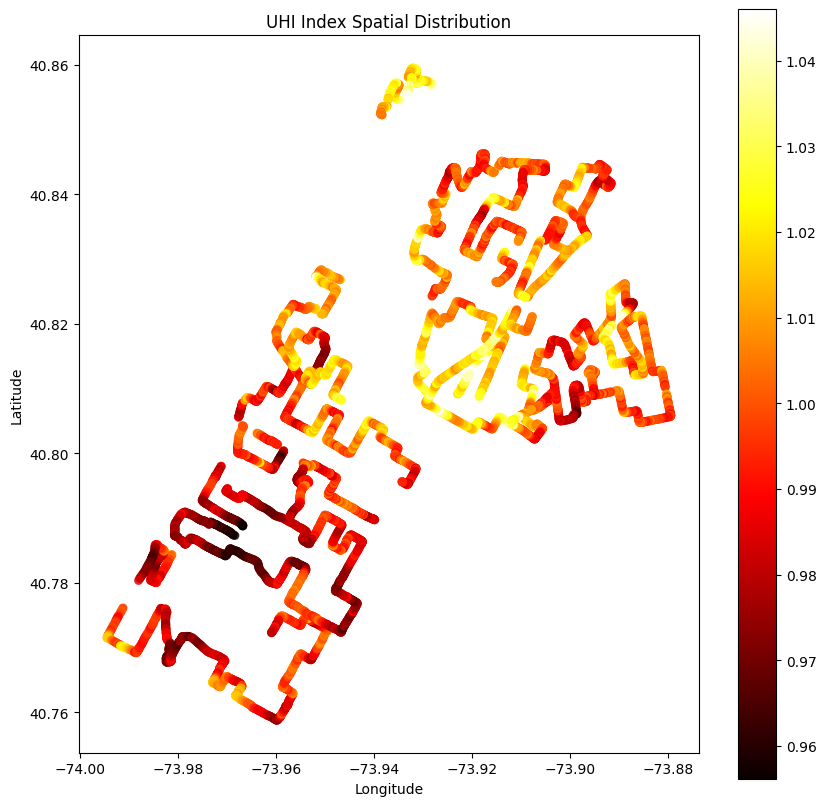

In [12]:
df = pd.read_csv("/content/uhi_with_all_features_weather_buildings.csv")

gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["Longitude"], df["Latitude"]),
    crs="EPSG:4326"
)

# Plotting on the map
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(
    ax=ax,
    column='UHI Index',
    cmap='hot',
    legend=True,
    markersize=30,
    alpha=0.7
)
ax.set_title("UHI Index Spatial Distribution")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

# Correlation among features

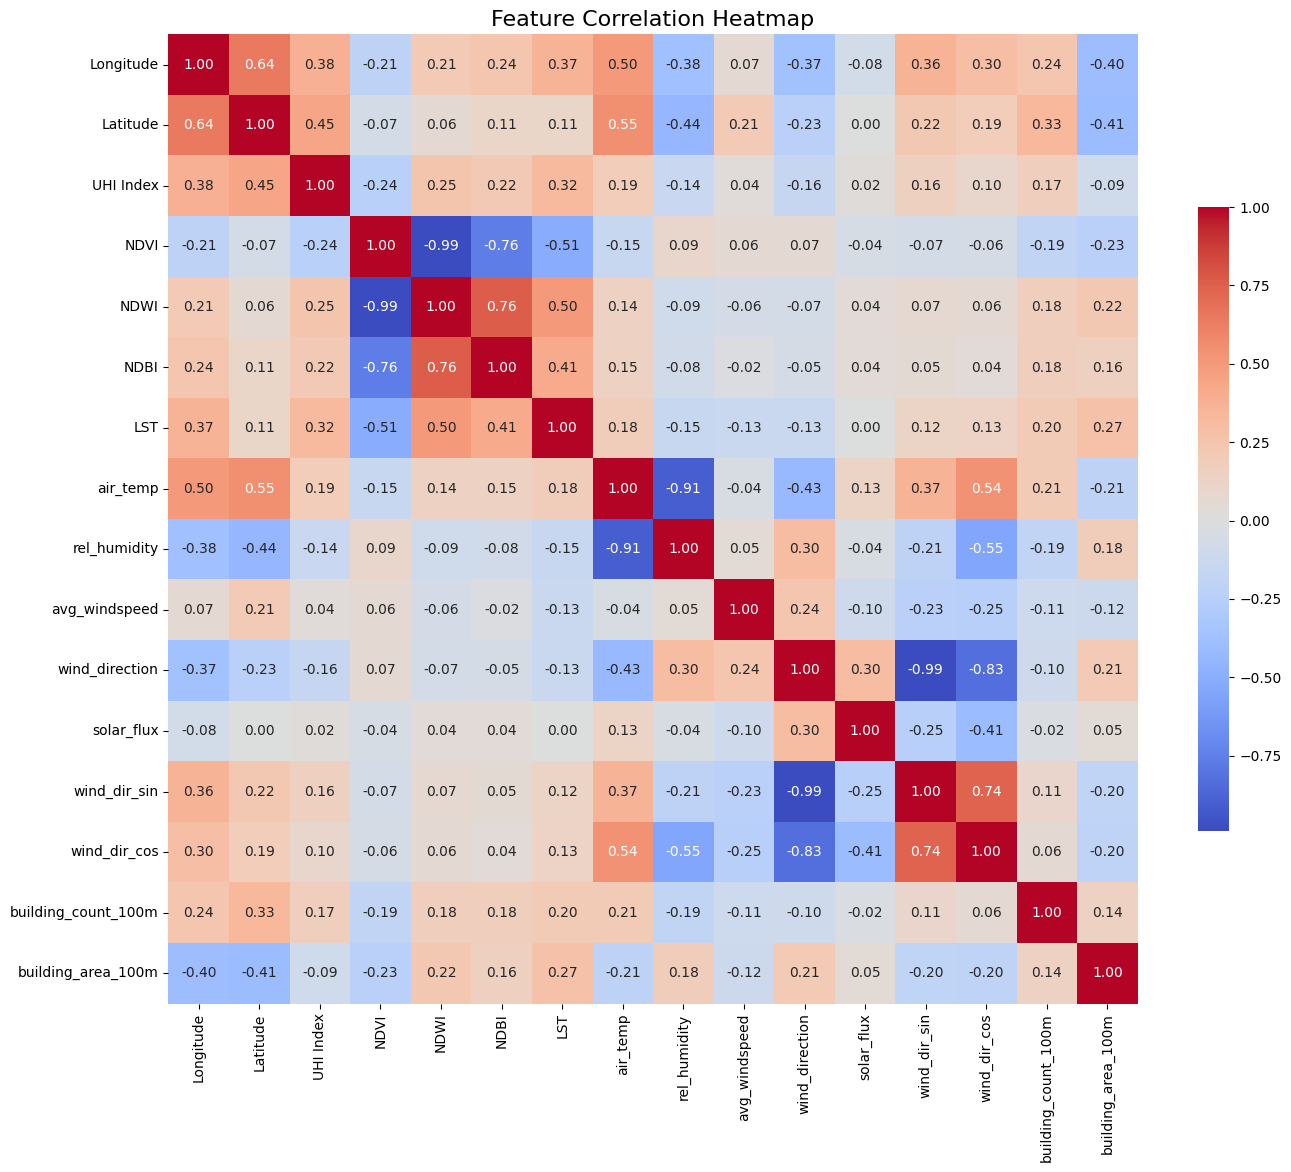

In [13]:
# Load the dataset
df = pd.read_csv("/content/uhi_with_all_features_weather_buildings.csv")

# Compute the correlation matrix (only for numeric columns)
corr = df.select_dtypes(include=[float, int]).corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={'shrink': 0.6})
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

# Random forest

### Random train/val split

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv("/content/uhi_with_all_features_weather_buildings.csv")
# Define features and target
features = [
    "NDVI", "NDWI", "NDBI", "LST",
    "air_temp", "rel_humidity", "avg_windspeed",
    "wind_dir_sin", "wind_dir_cos", "solar_flux",
    "building_count_100m", "building_area_100m"
]
X = df[features]
y = df["UHI Index"]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prediction and evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Evaluation:")
print(f"  R² Score : {r2:.4f}")
print(f"  RMSE     : {rmse:.4f}")
print(f"  MAE      : {mae:.4f}")

Random Forest Evaluation:
  R² Score : 0.9486
  RMSE     : 0.0037
  MAE      : 0.0025


### Sequential train/val split

In [23]:
# Load the dataset
df = pd.read_csv("/content/uhi_with_all_features_weather_buildings.csv")
# Define features and target
df = df.sort_values("datetime").reset_index(drop=True)

features = [
    "NDVI", "NDWI", "NDBI", "LST",
    "air_temp", "rel_humidity", "avg_windspeed",
    "wind_dir_sin", "wind_dir_cos", "solar_flux",
    "building_count_100m", "building_area_100m"
]
X = df[features]
y = df["UHI Index"]

split_index = int(len(df) * 0.8)
X_train_seq = X.iloc[:split_index]
y_train_seq = y.iloc[:split_index]
X_test_seq = X.iloc[split_index:]
y_test_seq = y.iloc[split_index:]

# Build and train the model on sequential split
model_seq = RandomForestRegressor(n_estimators=100, random_state=42)
model_seq.fit(X_train_seq, y_train_seq)

# Prediction and evaluation
y_pred_seq = model_seq.predict(X_test_seq)
mse_seq = mean_squared_error(y_test_seq, y_pred_seq)
rmse_seq = np.sqrt(mse_seq)
mae_seq = mean_absolute_error(y_test_seq, y_pred_seq)
r2_seq = r2_score(y_test_seq, y_pred_seq)

print(f"Random Forest Evaluation (Sequential Split):")
print(f"  R² Score : {r2_seq:.4f}")
print(f"  RMSE     : {rmse_seq:.4f}")
print(f"  MAE      : {mae_seq:.4f}")

Random Forest Evaluation (Sequential Split):
  R² Score : 0.1763
  RMSE     : 0.0138
  MAE      : 0.0110


## Feature importance (random forest)

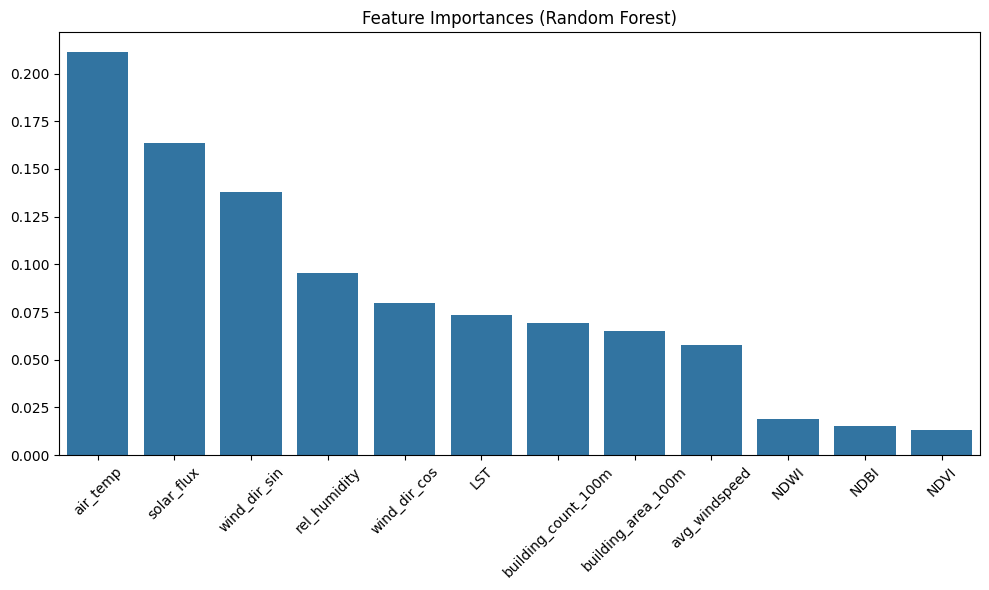

In [ ]:
# Visualize feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
sns.barplot(x=np.array(features)[indices], y=importances[indices])
plt.title("Feature Importances (Random Forest)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Distribution of SHAP values for all features (random forest)

100%|===================| 11228/11229 [18:31<00:00]       

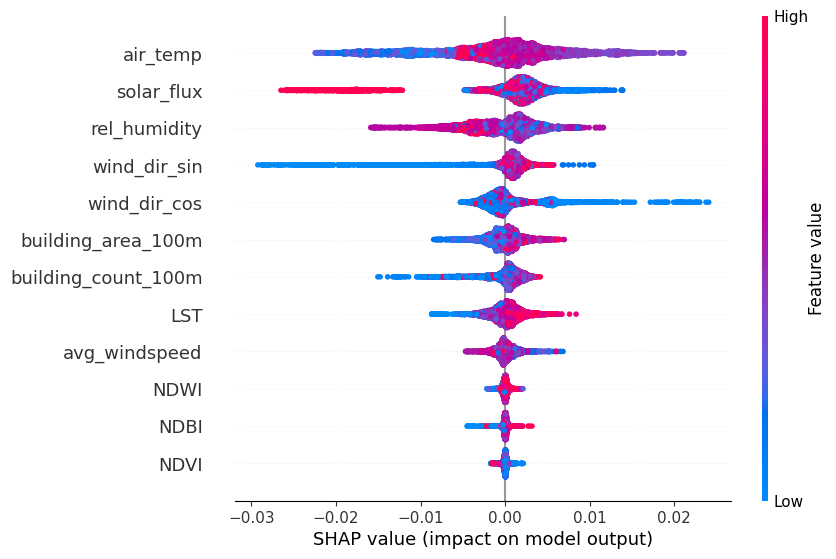

In [ ]:
# data
df = pd.read_csv("/content/uhi_with_all_features_weather_buildings.csv")
features = [
    "NDVI", "NDWI", "NDBI", "LST",
    "air_temp", "rel_humidity", "avg_windspeed",
    "wind_dir_sin", "wind_dir_cos", "solar_flux",
    "building_count_100m", "building_area_100m"
]
X = df[features]
y = df["UHI Index"]

# Build and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Use SHAP TreeExplainer
explainer = shap.Explainer(rf_model, X)
shap_values = explainer(X)

# Summary plot (distribution of SHAP values for all features)
shap.plots.beeswarm(shap_values, max_display=12)

# XGBoost

### Random train/val split

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv("/content/uhi_with_all_features_weather_buildings.csv")

# Define features and target
features = [
    "NDVI", "NDWI", "NDBI", "LST",
    "air_temp", "rel_humidity", "avg_windspeed",
    "wind_dir_sin", "wind_dir_cos", "solar_flux",
    "building_count_100m", "building_area_100m"
]
X = df[features]
y = df["UHI Index"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Evaluation:")
print(f"  R² Score : {r2:.4f}")
print(f"  RMSE     : {rmse:.4f}")
print(f"  MAE      : {mae:.4f}")

XGBoost Evaluation:
  R² Score : 0.9260
  RMSE     : 0.0044
  MAE      : 0.0033


### Sequential train/val split

In [24]:
# Sort by datetime
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime").reset_index(drop=True)

# Define features and target again (after sort)
X = df[features]
y = df["UHI Index"]

# Sequential split: first 80% for training, last 20% for testing
split_index = int(len(df) * 0.8)
X_train_seq = X.iloc[:split_index]
y_train_seq = y.iloc[:split_index]
X_test_seq = X.iloc[split_index:]
y_test_seq = y.iloc[split_index:]

# Train XGBoost model on sequential split
model_seq = xgb.XGBRegressor(n_estimators=100, random_state=42)
model_seq.fit(X_train_seq, y_train_seq)

# Predict and evaluate
y_pred_seq = model_seq.predict(X_test_seq)
rmse_seq = np.sqrt(mean_squared_error(y_test_seq, y_pred_seq))
mae_seq = mean_absolute_error(y_test_seq, y_pred_seq)
r2_seq = r2_score(y_test_seq, y_pred_seq)

print(f"XGBoost Evaluation (Sequential Split):")
print(f"  R² Score : {r2_seq:.4f}")
print(f"  RMSE     : {rmse_seq:.4f}")
print(f"  MAE      : {mae_seq:.4f}")

XGBoost Evaluation (Sequential Split):
  R² Score : 0.2101
  RMSE     : 0.0136
  MAE      : 0.0111


## Feature importance (XGBoost)

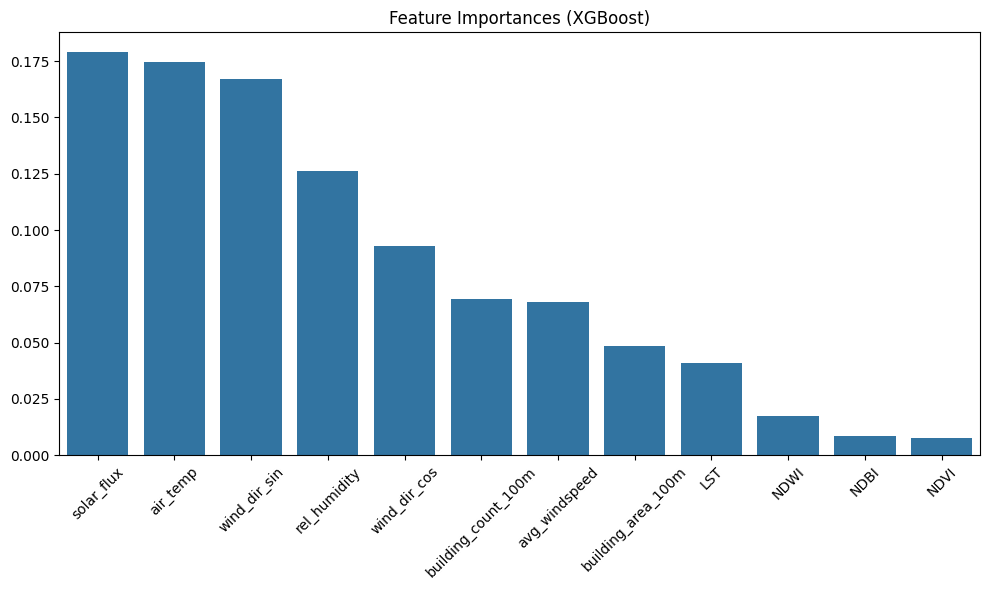

In [ ]:
# Visualize feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=np.array(features)[indices], y=importances[indices])
plt.title("Feature Importances (XGBoost)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Distribution of SHAP values for all features (XGBoost)

 99%|===================| 11158/11229 [00:51<00:00]       

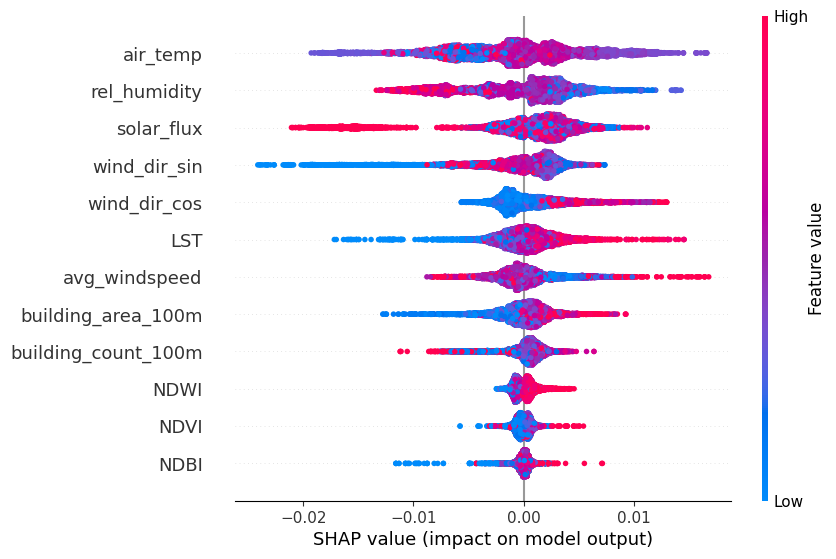

In [ ]:
# Load data and model (assumed to already exist)
df = pd.read_csv("/content/uhi_with_all_features_weather_buildings.csv")
features = [
    "NDVI", "NDWI", "NDBI", "LST",
    "air_temp", "rel_humidity", "avg_windspeed",
    "wind_dir_sin", "wind_dir_cos", "solar_flux",
    "building_count_100m", "building_area_100m"
]
X = df[features]
y = df["UHI Index"]

# Rebuild the XGBoost model (or reuse if already defined)
model = xgb.XGBRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Global feature importance
shap.plots.beeswarm(shap_values, max_display=12)

# MLP (hidden_layer_sizes=(64, 32))

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load the dataset
df = pd.read_csv("/content/uhi_with_all_features_weather_buildings.csv")

# Define features and target
features = [
    "NDVI", "NDWI", "NDBI", "LST",
    "air_temp", "rel_humidity", "avg_windspeed",
    "wind_dir_sin", "wind_dir_cos", "solar_flux",
    "building_count_100m", "building_area_100m"
]
X = df[features]
y = df["UHI Index"]

# Preprocessing (scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build and train the MLP model
model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', alpha=1e-4, max_iter=10000, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MLP Evaluation:")
print(f"  R² Score : {r2:.4f}")
print(f"  RMSE     : {rmse:.4f}")
print(f"  MAE      : {mae:.4f}")

MLP Evaluation:
  R² Score : -0.6756
  RMSE     : 0.0210
  MAE      : 0.0164


## Feature importance (permutation importance)

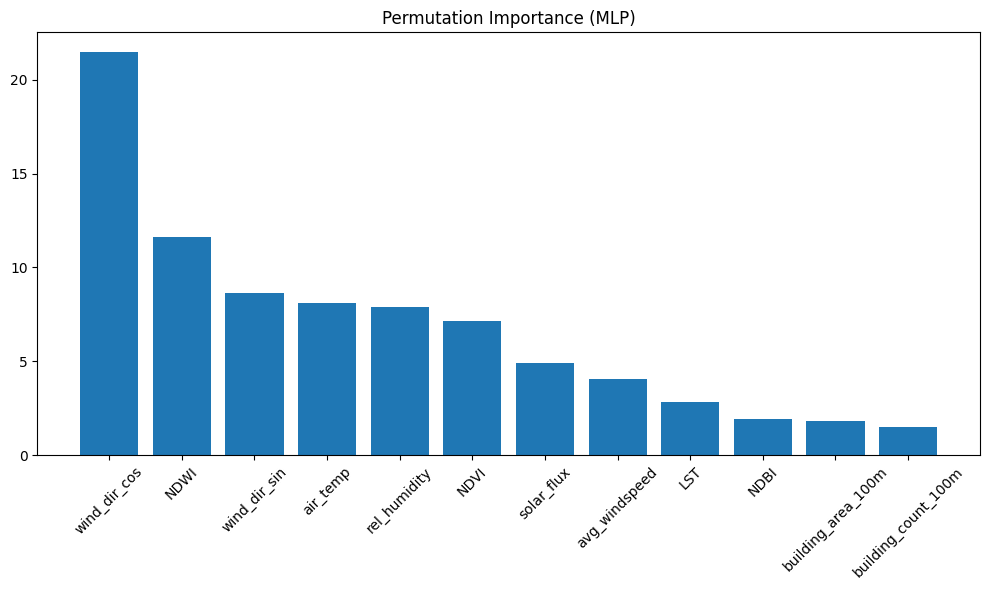

In [ ]:
from sklearn.inspection import permutation_importance

# Permutation Importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Plot the result
sorted_idx = result.importances_mean.argsort()[::-1]
plt.figure(figsize=(10, 6))
plt.bar(np.array(features)[sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Importance (MLP)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# MLP hidden_layer_sizes=(128, 64, 32)

In [ ]:
# Load the dataset
df = pd.read_csv("/content/uhi_with_all_features_weather_buildings.csv")

# Define features and target
features = [
    "NDVI", "NDWI", "NDBI", "LST",
    "air_temp", "rel_humidity", "avg_windspeed",
    "wind_dir_sin", "wind_dir_cos", "solar_flux",
    "building_count_100m", "building_area_100m"
]
X = df[features]
y = df["UHI Index"]

# Preprocessing (scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build and train the MLP model
model = MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation='relu', alpha=1e-4, max_iter=10000, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MLP Evaluation:")
print(f"  R² Score : {r2:.4f}")
print(f"  RMSE     : {rmse:.4f}")
print(f"  MAE      : {mae:.4f}")

MLP Evaluation:
  R² Score : 0.1501
  RMSE     : 0.0149
  MAE      : 0.0117


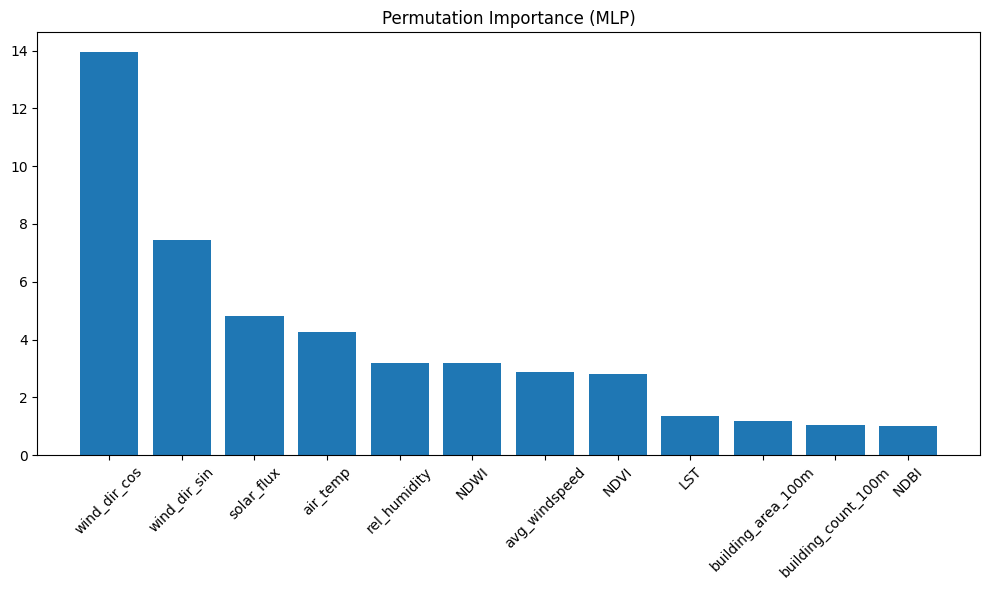

In [ ]:
from sklearn.inspection import permutation_importance

# Permutation Importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Plot the result
sorted_idx = result.importances_mean.argsort()[::-1]
plt.figure(figsize=(10, 6))
plt.bar(np.array(features)[sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Importance (MLP)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## MLP hidden_layer_sizes=(256, 128, 64, 32)

In [ ]:
# Load the dataset
df = pd.read_csv("/content/uhi_with_all_features_weather_buildings.csv")

# Define features and target
features = [
    "NDVI", "NDWI", "NDBI", "LST",
    "air_temp", "rel_humidity", "avg_windspeed",
    "wind_dir_sin", "wind_dir_cos", "solar_flux",
    "building_count_100m", "building_area_100m"
]
X = df[features]
y = df["UHI Index"]

# Preprocessing (scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build and train the MLP model
model = MLPRegressor(hidden_layer_sizes=(256, 128, 64, 32), activation='relu', alpha=1e-4, max_iter=10000, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MLP Evaluation:")
print(f"  R² Score : {r2:.4f}")
print(f"  RMSE     : {rmse:.4f}")
print(f"  MAE      : {mae:.4f}")

MLP Evaluation:
  R² Score : 0.5391
  RMSE     : 0.0110
  MAE      : 0.0088


## MLP hidden_layer_sizes=(512, 256, 128, 64, 32)

In [ ]:
# Load the dataset
df = pd.read_csv("/content/uhi_with_all_features_weather_buildings.csv")

# Define features and target
features = [
    "NDVI", "NDWI", "NDBI", "LST",
    "air_temp", "rel_humidity", "avg_windspeed",
    "wind_dir_sin", "wind_dir_cos", "solar_flux",
    "building_count_100m", "building_area_100m"
]
X = df[features]
y = df["UHI Index"]

# Preprocessing (scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build and train the MLP model
model = MLPRegressor(hidden_layer_sizes=(512, 256, 128, 64, 32), activation='relu', alpha=1e-4, max_iter=10000, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MLP Evaluation:")
print(f"  R² Score : {r2:.4f}")
print(f"  RMSE     : {rmse:.4f}")
print(f"  MAE      : {mae:.4f}")

MLP Evaluation:
  R² Score : 0.6169
  RMSE     : 0.0100
  MAE      : 0.0079


# Ensemble

In [ ]:
df = pd.read_csv("/content/uhi_with_all_features_weather_buildings.csv")

features = [
    "NDVI", "NDWI", "NDBI", "LST",
    "air_temp", "rel_humidity", "avg_windspeed",
    "wind_dir_sin", "wind_dir_cos", "solar_flux",
    "building_count_100m", "building_area_100m"
]
X = df[features]
y = df["UHI Index"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

mlp_model = MLPRegressor(hidden_layer_sizes=(512, 256, 128, 64, 32), activation='relu', alpha=1e-4, max_iter=10000, random_state=42)
mlp_model.fit(X_train_scaled, y_train)

rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
mlp_pred = mlp_model.predict(X_test_scaled)

ensemble_simple = (rf_pred + xgb_pred + mlp_pred) / 3
ensemble_weighted = 0.5 * rf_pred + 0.4 * xgb_pred + 0.1 * mlp_pred

def evaluate(y_true, y_pred, label=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} Evaluation:")
    print(f"  R² Score : {r2:.4f}")
    print(f"  RMSE     : {rmse:.4f}")
    print(f"  MAE      : {mae:.4f}")

evaluate(y_test, rf_pred, label="Random Forest")
evaluate(y_test, xgb_pred, label="XGBoost")
evaluate(y_test, mlp_pred, label="MLP")

evaluate(y_test, ensemble_simple, label="Ensemble (Simple Average)")
evaluate(y_test, ensemble_weighted, label="Ensemble (Weighted Average)")

Random Forest Evaluation:
  R² Score : 0.9486
  RMSE     : 0.0037
  MAE      : 0.0025
XGBoost Evaluation:
  R² Score : 0.9260
  RMSE     : 0.0044
  MAE      : 0.0033
MLP Evaluation:
  R² Score : 0.6006
  RMSE     : 0.0102
  MAE      : 0.0080
Ensemble (Simple Average) Evaluation:
  R² Score : 0.8990
  RMSE     : 0.0052
  MAE      : 0.0040
Ensemble (Weighted Average) Evaluation:
  R² Score : 0.9390
  RMSE     : 0.0040
  MAE      : 0.0030
